## Loading Data

In [6]:
import os
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import date, datetime

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [176]:
months = ['Gener', 'Febrer', 'Marc', 'Abril', 'Maig', 'Juny', 'Juliol', 'Agost', 'Setembre', 'Octubre', 'Novembre', 'Desembre']

In [ ]:
i2m = list(zip(range(1,13), months))
for year in [2023, 2022, 2021, 2020, 2019]:
    for month, month_name in i2m:        
        os.system(f"wget 'https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z'")
        os.system(f"7z x '{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z'")
        os.system(f"rm '{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z'")

In [15]:
df = pd.DataFrame()

In [16]:
def get_datetime(miliseconds: int):
    return datetime.fromtimestamp(miliseconds)

def create_date_df(df: pd.DataFrame):
    df['date'] = pd.to_datetime(
        df['last_reported'].apply(lambda x: get_datetime(x))
    )
    
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['hour'] = df['date'].dt.hour
    
    return df

In [118]:
def create_date_time(row):
    return datetime(
        int(row['year']),
        int(row['month']),
        int(row['day']),
        int(row['hour'])
    )

In [182]:
def process_new_df(new_df: pd.DataFrame):
    # Unique values
    new_df = new_df.drop_duplicates()
    new_df = new_df.dropna(subset=['last_reported', 'last_updated'], axis=0)
    new_df = new_df.sort_values('last_reported', ascending=True)
    
    # Convert some categorical into numerical
    new_df.status = np.where(new_df.status == 'IN_SERVICE', 1, 0)
    new_df.is_charging_station = np.where(new_df.is_charging_station, 1, 0)
    
    # Create the dates from timestamp and group statistics
    new_df = create_date_df(new_df)
    new_df = new_df\
        .groupby(['station_id', 'year', 'month', 'day', 'hour'])\
        .mean(numeric_only=True)\
        .reset_index()
    
    # Creation of the dates
    new_df['date_time'] = new_df.apply(lambda row: create_date_time(row), axis=1)
    new_df['date'] = new_df.date_time.dt.date
    
    return new_df

In [ ]:
for csv in tqdm(os.listdir('./data')):
    new_df = pd.read_csv('./data/' + csv)
    new_df = process_new_df(new_df)
    
    # Filter out incorrect dates
    year, month, *_ = csv.split('_')
    year, month = int(year), int(month)
    new_df = new_df[(new_df.year == year) & (new_df.month == month)]
    
    df = pd.concat(
        [df, new_df], 
        axis=0
    )


  0%|                                                                                                                           | 0/50 [00:00<?, ?it/s]

In [18]:
# Handle NaN: Assume that the NaN in traffic is 0
df.traffic = df.traffic.replace(np.nan, 0)

In [20]:
df.shape

(16401766, 18)

In [21]:
df.head()

,station_id,year,month,day,hour,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,is_installed,is_renting,is_returning,last_reported,is_charging_station,status,last_updated,ttl,traffic
0,1,2020,5,31,23,9.000000,9.000000,0.0,35.000000,1.0,1.0,1.0,1.590962e+09,1.0,1.0,1.590962e+09,2.000000,0.0
1,1,2020,6,1,0,7.727273,7.727273,0.0,36.272727,1.0,1.0,1.0,1.590964e+09,1.0,1.0,1.590964e+09,17.363636,0.0
2,1,2020,6,1,1,8.076923,8.076923,0.0,35.923077,1.0,1.0,1.0,1.590968e+09,1.0,1.0,1.590968e+09,15.461538,0.0
3,1,2020,6,1,2,7.750000,7.750000,0.0,36.250000,1.0,1.0,1.0,1.590971e+09,1.0,1.0,1.590972e+09,14.083333,0.0
4,1,2020,6,1,3,8.000000,8.000000,0.0,36.000000,1.0,1.0,1.0,1.590975e+09,1.0,1.0,1.590975e+09,14.250000,0.0


Will give back a date time field.

In [ ]:
df['date_time'] = df.apply(lambda row: create_date_time(row), axis=1)
df['date'] = df.date_time.dt.date

### Add station information

In [22]:
def get_station_json(
    url: str = 'https://opendata-ajuntament.barcelona.cat/data/dataset/bd2462df-6e1e-4e37-8205-a4b8e7313b84/resource/e5adca8d-98bf-42c3-9b9c-364ef0a80494/download'
):
    
    res = requests.get(url)
    return res.json()

In [23]:
station_json = get_station_json()

In [24]:
station_df = pd.DataFrame(station_json['data']['stations'])
station_df.head()

,station_id,name,physical_configuration,lat,lon,altitude,address,post_code,capacity,is_charging_station,nearby_distance,_ride_code_support,rental_uris,cross_street
0,1,"GRAN VIA CORTS CATALANES, 760",ELECTRICBIKESTATION,41.397978,2.180107,16.0,"GRAN VIA CORTS CATALANES, 760",08013,46,True,1000.0,True,None,NaN
1,2,"C/ ROGER DE FLOR, 126",ELECTRICBIKESTATION,41.395488,2.177198,17.0,"C/ ROGER DE FLOR, 126",08013,29,True,1000.0,True,None,NaN
2,3,"C/ NÀPOLS, 82",ELECTRICBIKESTATION,41.394156,2.181331,11.0,"C/ NÀPOLS, 82",08013,27,True,1000.0,True,None,NaN
3,4,"C/ RIBES, 13",ELECTRICBIKESTATION,41.393317,2.181248,8.0,"C/ RIBES, 13",08013,21,True,1000.0,True,None,NaN
4,5,"PG. LLUIS COMPANYS, 11 (ARC TRIOMF)",ELECTRICBIKESTATION,41.391103,2.180176,7.0,"PG. LLUIS COMPANYS, 11 (ARC TRIOMF)",08018,39,True,1000.0,True,None,NaN


In [25]:
# Some fields are not going to be used
station_drop_fields = [
    'physical_configuration',          # unique value: ELECTRICBIKESTATION
    '_ride_code_support',              # unique value: all True
    'nearby_distance',                 # unique value: 1000
    'name', 'address', 'post_code',    # too specific to each of the stations
    'is_charging_station',             # already in the main df
    'rental_uris', 'cross_street',     # vast majority are none
    
]

In [26]:
station_df = station_df.drop(station_drop_fields, axis=1)
station_df.head()

,station_id,lat,lon,altitude,capacity
0,1,41.397978,2.180107,16.0,46
1,2,41.395488,2.177198,17.0,29
2,3,41.394156,2.181331,11.0,27
3,4,41.393317,2.181248,8.0,21
4,5,41.391103,2.180176,7.0,39


In [27]:
df = pd.merge(df, station_df)

In [28]:
df.head()

,station_id,year,month,day,hour,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,is_installed,...,last_reported,is_charging_station,status,last_updated,ttl,traffic,lat,lon,altitude,capacity
0,1,2020,5,31,23,9.000000,9.000000,0.0,35.000000,1.0,...,1.590962e+09,1.0,1.0,1.590962e+09,2.000000,0.0,41.397978,2.180107,16.0,46
1,1,2020,6,1,0,7.727273,7.727273,0.0,36.272727,1.0,...,1.590964e+09,1.0,1.0,1.590964e+09,17.363636,0.0,41.397978,2.180107,16.0,46
2,1,2020,6,1,1,8.076923,8.076923,0.0,35.923077,1.0,...,1.590968e+09,1.0,1.0,1.590968e+09,15.461538,0.0,41.397978,2.180107,16.0,46
3,1,2020,6,1,2,7.750000,7.750000,0.0,36.250000,1.0,...,1.590971e+09,1.0,1.0,1.590972e+09,14.083333,0.0,41.397978,2.180107,16.0,46
4,1,2020,6,1,3,8.000000,8.000000,0.0,36.000000,1.0,...,1.590975e+09,1.0,1.0,1.590975e+09,14.250000,0.0,41.397978,2.180107,16.0,46


### Add Weather information

In [173]:
df['date'].min()

datetime.date(1970, 1, 1)

In [175]:
df[df['date'] == date(1970, 1, 1)]

,station_id,year,month,day,hour,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,is_installed,...,is_early_morning,is_morning,is_noon,is_eve,is_night,day_info,hour_info,month_info,date,covid_cases
1228362,43,1970,1,1,1,0.0,0.0,0.0,0.000000,1.000000,...,0,0,0,0,0,weekday,late_night,winter,1970-01-01,6.0
11356401,355,1970,1,1,1,0.0,0.0,0.0,0.000000,0.000000,...,0,0,0,0,0,weekday,late_night,winter,1970-01-01,6.0
13133006,411,1970,1,1,1,0.0,0.0,0.0,0.000000,1.000000,...,0,0,0,0,0,weekday,late_night,winter,1970-01-01,6.0
13738715,434,1970,1,1,1,0.0,0.0,0.0,0.000000,1.000000,...,0,0,0,0,0,weekday,late_night,winter,1970-01-01,6.0
13752473,435,1970,1,1,1,0.0,0.0,0.0,0.000000,0.000000,...,0,0,0,0,0,weekday,late_night,winter,1970-01-01,6.0
13893629,440,1970,1,1,1,0.0,0.0,0.0,0.000000,1.000000,...,0,0,0,0,0,weekday,late_night,winter,1970-01-01,6.0
13944492,442,1970,1,1,1,0.0,0.0,0.0,0.000000,1.000000,...,0,0,0,0,0,weekday,late_night,winter,1970-01-01,6.0
13969788,443,1970,1,1,1,0.0,0.0,0.0,0.000000,1.000000,...,0,0,0,0,0,weekday,late_night,winter,1970-01-01,6.0
14071512,447,1970,1,1,1,0.0,0.0,0.0,0.000000,1.000000,...,0,0,0,0,0,weekday,late_night,winter,1970-01-01,6.0
14097348,448,1970,1,1,1,0.0,0.0,0.0,0.000000,0.997642,...,0,0,0,0,0,weekday,late_night,winter,1970-01-01,6.0


In [174]:
df

,station_id,year,month,day,hour,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,is_installed,...,is_early_morning,is_morning,is_noon,is_eve,is_night,day_info,hour_info,month_info,date,covid_cases
0,1,2020,5,31,23,9.000000,9.000000,0.000000,35.000000,1.0,...,0,0,0,0,1,weekend,night,spring,2020-05-31,7.0
1,1,2020,6,1,0,7.727273,7.727273,0.000000,36.272727,1.0,...,0,0,0,0,0,weekday,late_night,summer,2020-06-01,4.0
2,1,2020,6,1,1,8.076923,8.076923,0.000000,35.923077,1.0,...,0,0,0,0,0,weekday,late_night,summer,2020-06-01,4.0
3,1,2020,6,1,2,7.750000,7.750000,0.000000,36.250000,1.0,...,0,0,0,0,0,weekday,late_night,summer,2020-06-01,4.0
4,1,2020,6,1,3,8.000000,8.000000,0.000000,36.000000,1.0,...,0,0,0,0,0,weekday,late_night,summer,2020-06-01,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16081695,431,2023,4,30,20,1.000000,1.000000,0.000000,19.000000,1.0,...,0,0,0,1,0,weekend,eve,spring,2023-04-30,6.0
16081696,431,2023,4,30,21,1.000000,1.000000,0.000000,19.000000,1.0,...,0,0,0,0,1,weekend,night,spring,2023-04-30,6.0
16081697,431,2023,4,30,22,1.250000,1.000000,0.250000,18.750000,1.0,...,0,0,0,0,1,weekend,night,spring,2023-04-30,6.0
16081698,431,2023,4,30,23,1.000000,1.000000,0.000000,19.000000,1.0,...,0,0,0,0,1,weekend,night,spring,2023-04-30,6.0


### Add Covid Information

The daily covid cases that there were in Barcelona

In [128]:
def get_covid_json(
    url: str = "https://opendata-ajuntament.barcelona.cat/data/api/action/datastore_search_sql?sql=SELECT%20*%20from%20%22f627ac0a-d05f-416d-9773-eeb464a3fc44%22%20WHERE%20%22Nom_Indicador%22%20LIKE%20%27Casos%20de%20COVID-19%20a%20Barcelona%20(diari)%27"
):
    
    res_covid = requests.get(url)
    return res_covid.json()['result']['records']

In [129]:
covid_json = get_covid_json()

In [130]:
covid_df = pd.DataFrame(covid_json)
covid_df.head()

,Nom_Variable,Font,Data_Indicador,Territori,_full_text,Frequencia_Indicador,Valor,_id,Nom_Indicador,Unitat
0,,Agència de Salut Pública de Barcelona,2020-02-25,Barcelona,'-02':11 '-19':16 '-25':12 '1':9 '2020':10 'ag...,diari,1,1,Casos de COVID-19 a Barcelona (diari),Nombre
1,,Agència de Salut Pública de Barcelona,2020-02-26,Barcelona,'-02':11 '-19':17 '-26':12 '0':9 '2020':10 'ag...,diari,0,2,Casos de COVID-19 a Barcelona (diari),Nombre
2,,Agència de Salut Pública de Barcelona,2020-02-27,Barcelona,'-02':11 '-19':17 '-27':12 '0':9 '2020':10 'ag...,diari,0,3,Casos de COVID-19 a Barcelona (diari),Nombre
3,,Agència de Salut Pública de Barcelona,2020-02-28,Barcelona,'-02':19 '-19':13 '-28':20 '0':9 '2020':18 'ag...,diari,0,4,Casos de COVID-19 a Barcelona (diari),Nombre
4,,Agència de Salut Pública de Barcelona,2020-02-29,Barcelona,'-02':19 '-19':14 '-29':20 '0':9 '2020':18 'ag...,diari,0,5,Casos de COVID-19 a Barcelona (diari),Nombre


In [131]:
covid_df.shape

(773, 10)

In [132]:
covid_df = covid_df[['Data_Indicador', 'Valor']]
covid_df.head()

,Data_Indicador,Valor
0,2020-02-25,1
1,2020-02-26,0
2,2020-02-27,0
3,2020-02-28,0
4,2020-02-29,0


In [133]:
covid_df['date'] = pd.to_datetime(covid_df.Data_Indicador).dt.date

In [134]:
covid_df = covid_df\
    .drop('Data_Indicador', axis=1)\
    .rename(columns={'Valor': 'covid_cases'})

In [135]:
df = pd.merge(df, covid_df, how='left')

We only have NaN values afterwards (not previous to the start of Covid).

For those NaN, we will replace them by a percentile that is at the bottom (still not 0, as there are cases).

In [140]:
df.covid_cases = df.covid_cases.astype('float')

In [141]:
df.covid_cases.describe()

count    8.481056e+06
mean     6.541112e+02
std      1.226443e+03
min      0.000000e+00
25%      9.000000e+01
50%      2.690000e+02
75%      5.800000e+02
max      8.656000e+03
Name: covid_cases, dtype: float64

<AxesSubplot:>

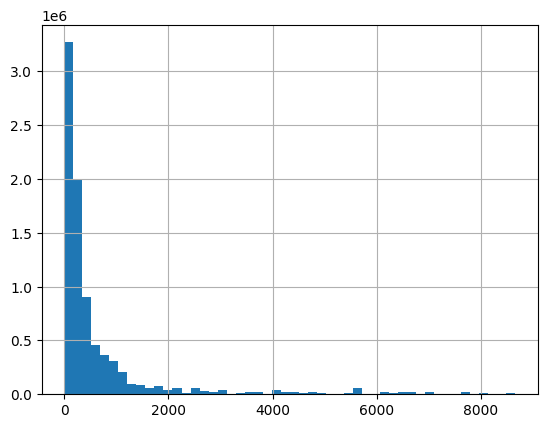

In [146]:
df.covid_cases.hist(bins=50)

In [155]:
def fill_with_percentile(
    df: pd.DataFrame, 
    column: str, 
    percentile: float = 0.03,
    logging: bool = True
):
    
    quantile_value = df[column].quantile(percentile)
    
    if logging:
        print(f'Percentile {percentile} value is: ', quantile_value)
        
    df[column] = df[column].fillna(quantile_covid_cases)
    
    return df

In [157]:
df = fill_with_percentile(df, 'covid_cases')

Percentile 0.03 value is:  6.0


### Datetime Information

In [82]:
# Would need to get the dummies for them
date_time_fields = ['day_info', 'hour_info', 'month_info']

Related to the **day** (weekend).

In [75]:
def get_day_info(date_time):
    return 'weekend' if date_time.weekday() in [5, 6] else 'weekday'

In [76]:
df['day_info'] = df.date_time.apply(lambda x: get_day_info(x))

Related to the **hour** (which time of day it was).

In [74]:
def get_hour_info(date_time):
    if date_time.hour in range(5):
        return 'late_night'

    elif date_time.hour in range(5, 9):
        return 'early_morning'

    elif date_time.hour in range(9, 13):
        return 'morning'
    
    elif date_time.hour in range(13, 17):
        return 'noon'
    
    elif date_time.hour in range(17, 21):
        return 'eve'
    
    return 'night'

In [77]:
df['hour_info'] = df.date_time.apply(lambda x: get_hour_info(x))

Related to the **month** (season).

In [79]:
def get_month_info(date):
    if date.month in (3, 4, 5):
        return 'spring'
    
    elif date.month in (6, 7, 8):
        return 'summer'
    
    elif date.month in (9, 10, 11):
        return 'autumn'
    
    return 'winter'

In [80]:
df['month_info'] = df.date_time.apply(lambda x: get_month_info(x))

In [81]:
df.head()

,station_id,year,month,day,hour,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,is_installed,...,is_weekend,is_late_night,is_early_morning,is_morning,is_noon,is_eve,is_night,day_info,hour_info,month_info
0,1,2020,5,31,23,9.000000,9.000000,0.0,35.000000,1.0,...,1,0,0,0,0,0,1,weekend,night,spring
1,1,2020,6,1,0,7.727273,7.727273,0.0,36.272727,1.0,...,0,1,0,0,0,0,0,weekday,late_night,summer
2,1,2020,6,1,1,8.076923,8.076923,0.0,35.923077,1.0,...,0,1,0,0,0,0,0,weekday,late_night,summer
3,1,2020,6,1,2,7.750000,7.750000,0.0,36.250000,1.0,...,0,1,0,0,0,0,0,weekday,late_night,summer
4,1,2020,6,1,3,8.000000,8.000000,0.0,36.000000,1.0,...,0,1,0,0,0,0,0,weekday,late_night,summer


### Train / Val / Test Split

In [164]:
df.head()

,station_id,year,month,day,hour,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,is_installed,...,is_early_morning,is_morning,is_noon,is_eve,is_night,day_info,hour_info,month_info,date,covid_cases
0,1,2020,5,31,23,9.000000,9.000000,0.0,35.000000,1.0,...,0,0,0,0,1,weekend,night,spring,2020-05-31,7.0
1,1,2020,6,1,0,7.727273,7.727273,0.0,36.272727,1.0,...,0,0,0,0,0,weekday,late_night,summer,2020-06-01,4.0
2,1,2020,6,1,1,8.076923,8.076923,0.0,35.923077,1.0,...,0,0,0,0,0,weekday,late_night,summer,2020-06-01,4.0
3,1,2020,6,1,2,7.750000,7.750000,0.0,36.250000,1.0,...,0,0,0,0,0,weekday,late_night,summer,2020-06-01,4.0
4,1,2020,6,1,3,8.000000,8.000000,0.0,36.000000,1.0,...,0,0,0,0,0,weekday,late_night,summer,2020-06-01,4.0


In [165]:
train_df = df[df.year != 2023]
test_df = df[df.year == 2023]

In [166]:
print('Train size: ', train_df.shape[0])
print('Test size: ', test_df.shape[0])

Train size:  14757802
Test size:  1323898


In [168]:
valid_df = test_df[test_df.month <= 3]
test_df = test_df[test_df.month > 3]

In [169]:
print('Valid size: ', valid_df.shape[0])
print('Test size: ', test_df.shape[0])

Valid size:  1024576
Test size:  299322


### Rolling Window

We need to create a rolling window for each of the data available.

In [163]:
train_df.head()

,station_id,year,month,day,hour,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,is_installed,...,is_early_morning,is_morning,is_noon,is_eve,is_night,day_info,hour_info,month_info,date,covid_cases
0,1,2020,5,31,23,9.000000,9.000000,0.0,35.000000,1.0,...,0,0,0,0,1,weekend,night,spring,2020-05-31,7.0
1,1,2020,6,1,0,7.727273,7.727273,0.0,36.272727,1.0,...,0,0,0,0,0,weekday,late_night,summer,2020-06-01,4.0
2,1,2020,6,1,1,8.076923,8.076923,0.0,35.923077,1.0,...,0,0,0,0,0,weekday,late_night,summer,2020-06-01,4.0
3,1,2020,6,1,2,7.750000,7.750000,0.0,36.250000,1.0,...,0,0,0,0,0,weekday,late_night,summer,2020-06-01,4.0
4,1,2020,6,1,3,8.000000,8.000000,0.0,36.000000,1.0,...,0,0,0,0,0,weekday,late_night,summer,2020-06-01,4.0


**TODO**: 
- Window function: ctx-4, ctx-3, ...

### Exploration